# Imports

In [1]:
# Standard library
import os
import random
import warnings
from pathlib import Path
from typing import Optional, Tuple, Union

# Third-party libraries
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.metrics import f1_score, jaccard_score
from tqdm import tqdm

# Configuration Function
This cell defines a get_script_config() function that sets up all paths and parameters needed for evaluating segmentation results. It uses pathlib to build project-relative paths for input data, masks, and output folders, ensuring portability. The function also includes flags to control which evaluation and visualization steps to run. The final configuration is printed for verification.

In [2]:
from pathlib import Path

def get_script_config():
    """
    Evaluation and visualization configuration for glomeruli segmentation.

    Folder assumptions (confirmed):
    - Input and GT masks are in: cerberus_inference/cerberus/data/{input, masks}
    - Predictions are in:        cerberus_inference/cerberus/data/output
    """

    # Resolve current working directory (should be from evaluation script)
    eval_dir = Path().resolve()

    # Correct path to cerberus/data (note the fix: 'cerberus' instead of 'cereberus')
    inference_data_dir = eval_dir.parent / "cerberus_inference" / "cerberus" / "data"
    output_dir = inference_data_dir / "output"

    config = {
        # Input and ground truth directories
        "input_dir": inference_data_dir / "input",
        "mask_dir": inference_data_dir / "masks",

        # Prediction output folders
        "base_output_dir": output_dir,
        "mat_folders_to_process": ["lumen_mat", "gland_mat", "nuclei_mat"],  # optionally add "pclass_mat"
        "overlay_folder_name": "overlay",

        # Visualization parameters
        "num_visualization_samples": 3,

        # Flags to enable/disable components
        "perform_overlay_evaluation": True,
        "perform_mat_evaluation": True,
        "perform_overlay_visualization": True,
        "perform_mat_visualization": True,
    }

    # Derived path for predicted overlay images
    config["overlay_pred_dir"] = config["base_output_dir"] / config["overlay_folder_name"]

    return config


# Image and Segmentation Utility Functions

This cell defines a set of utility functions for working with image segmentation tasks:

- `load_image_pil()`: Loads an image using PIL with error handling.
- `convert_to_numpy()`: Converts a PIL image to a NumPy array.
- `binarize_ground_truth_mask()`: Converts grayscale ground truth masks to binary masks.
- `binarize_color_overlay()`: Extracts binary masks from green overlay regions in RGB images.
- `load_and_binarize_mat_prediction()`: Loads `.mat` prediction files (e.g., `inst_map`) and binarizes them.
- `resize_pil_image()`: Resizes an image to a specified width and height.
- `calculate_segmentation_metrics()`: Computes Dice and IoU scores between ground truth and predicted masks.
- `apply_mask_overlay_pil()`: Applies a semi-transparent color overlay of a mask onto an RGB image.

In [3]:
def load_image_pil(path: Union[str, Path]) -> Optional[Image.Image]:
    """Loads an image using PIL."""
    try:
        return Image.open(path)
    except FileNotFoundError:
        warnings.warn(f"Image file not found at {path}")
    except Exception as e:
        warnings.warn(f"Could not load image {path}. Error: {e}")
    return None

def convert_to_numpy(pil_image: Optional[Image.Image]) -> Optional[np.ndarray]:
    """Converts a PIL image to a NumPy array."""
    return np.array(pil_image) if pil_image else None

def binarize_ground_truth_mask(gt_pil_image: Optional[Image.Image]) -> Optional[np.ndarray]:
    """
    Binarizes a ground truth mask.
    Any pixel value > 0 in grayscale is considered foreground.
    """
    if gt_pil_image is None:
        warnings.warn("binarize_ground_truth_mask received None image.")
        return None
    try:
        mask_array = np.array(gt_pil_image.convert('L'))
        return (mask_array > 0).astype(np.uint8)
    except Exception as e:
        warnings.warn(f"Error in binarize_ground_truth_mask: {e}")
        return None

def binarize_color_overlay(overlay_pil_image: Optional[Image.Image]) -> Optional[np.ndarray]:
    """
    Binarizes an overlay image by detecting green-ish areas.
    """
    if overlay_pil_image is None:
        return None
    rgb_array = convert_to_numpy(overlay_pil_image.convert("RGB"))
    if rgb_array is None:
        return None
    green_mask = (
        (rgb_array[:, :, 1] > 150) &
        (rgb_array[:, :, 0] < 150) &
        (rgb_array[:, :, 2] < 150)
    )
    return green_mask.astype(np.uint8)

def load_and_binarize_mat_prediction(mat_path: Union[str, Path]) -> Optional[np.ndarray]:
    """
    Loads a .mat file containing a segmentation map and binarizes it.
    """
    try:
        mat_data = loadmat(mat_path)
    except FileNotFoundError:
        warnings.warn(f".mat file not found at {mat_path}")
        return None
    except Exception as e:
        warnings.warn(f"Could not load .mat file {mat_path}. Error: {e}")
        return None

    for key in ["inst_map", "type_map", "pred_map"]:
        if key in mat_data and mat_data[key] is not None:
            return (mat_data[key] > 0).astype(np.uint8)

    warnings.warn(f"No suitable prediction map found in {mat_path}.")
    return None

def resize_pil_image(pil_image: Optional[Image.Image], target_size_wh: Tuple[int, int], mode=Image.NEAREST) -> Optional[Image.Image]:
    """Resizes a PIL image to the given (width, height)."""
    return pil_image.resize(target_size_wh, mode) if pil_image else None

def calculate_segmentation_metrics(gt_flat: np.ndarray, pred_flat: np.ndarray) -> Tuple[float, float]:
    """Calculates Dice and IoU scores between two flattened binary masks."""
    if gt_flat is None or pred_flat is None:
        return 0.0, 0.0
    if gt_flat.size == 0 and pred_flat.size == 0:
        return 1.0, 1.0
    if gt_flat.size == 0 or pred_flat.size == 0:
        return 0.0, 0.0
    return (
        f1_score(gt_flat, pred_flat, zero_division=0),
        jaccard_score(gt_flat, pred_flat, zero_division=0),
    )

def apply_mask_overlay_pil(
    image_pil: Optional[Image.Image],
    mask_np: Optional[np.ndarray],
    color_rgb_float: Tuple[float, float, float],
    alpha: float = 0.5
) -> Optional[Image.Image]:
    """
    Overlays a binary mask onto a PIL image with a semi-transparent color.
    """
    if image_pil is None or mask_np is None:
        return image_pil

    image_rgb_pil = image_pil.convert("RGB")
    image_np = np.array(image_rgb_pil)

    if mask_np.ndim == 3 and mask_np.shape[-1] == 1:
        mask_np = mask_np.squeeze(-1)
    elif mask_np.ndim != 2:
        return image_rgb_pil

    if image_np.shape[:2] != mask_np.shape:
        resized_mask = Image.fromarray(mask_np.astype(np.uint8) * 255).resize(
            (image_np.shape[1], image_np.shape[0]), Image.NEAREST
        )
        mask_np = (np.array(resized_mask) > 127).astype(np.uint8)

    overlay_np = image_np.copy()
    color_rgb_uint8 = (np.array(color_rgb_float) * 255).astype(np.uint8)

    if np.any(mask_np):
        for c in range(3):
            overlay_np[:, :, c] = np.where(
                mask_np == 1,
                (image_np[:, :, c] * (1 - alpha) + color_rgb_uint8[c] * alpha).astype(np.uint8),
                image_np[:, :, c]
            )

    return Image.fromarray(overlay_np)


# Overlay Prediction Evaluation Function

This function evaluates predicted overlay images (e.g., `.jpg` files colored with segmentation overlays) against ground truth binary masks (`.png` files). It performs the following steps:

- Loads overlay and ground truth images using PIL.
- Converts and binarizes both using color thresholding and grayscale binarization.
- Handles size mismatches by resizing overlays to match the ground truth mask.
- Computes Dice and IoU scores for each valid image pair.
- Prints the average metrics over all successfully evaluated images.


In [4]:
def evaluate_overlay_predictions(
    overlay_dir: Union[str, Path],
    ground_truth_dir: Union[str, Path],
    script_config: dict
) -> None:
    """
    Evaluates .jpg overlay predictions against ground truth .png masks.
    Computes Dice and IoU scores for each image and reports the averages.
    
    Parameters:
    - overlay_dir: Directory containing overlay prediction images (.jpg).
    - ground_truth_dir: Directory containing ground truth masks (.png).
    - script_config: Dictionary containing script settings and paths.
    """
    overlay_dir = Path(overlay_dir)
    ground_truth_dir = Path(ground_truth_dir)

    print(f"\n--- Evaluating Overlay Predictions: ---")

    if not overlay_dir.exists():
        warnings.warn(f"Overlay directory not found: {overlay_dir}. Skipping evaluation.")
        return

    overlay_files = sorted([f for f in overlay_dir.glob("*.jpg")])
    if not overlay_files:
        print("No .jpg overlay files found to evaluate.")
        return

    dice_scores = []
    iou_scores = []

    for overlay_path in tqdm(overlay_files, desc="Overlay Evaluation"):
        fname = overlay_path.name
        gt_path = ground_truth_dir / (overlay_path.stem + ".png")

        if not gt_path.exists():
            warnings.warn(f"Ground truth mask missing for {fname} (expected at {gt_path}), skipping.")
            continue

        overlay_pil = load_image_pil(overlay_path)
        gt_pil = load_image_pil(gt_path)

        if overlay_pil is None or gt_pil is None:
            warnings.warn(f"Failed to load overlay or ground truth for {fname}, skipping.")
            continue

        if overlay_pil.size != gt_pil.size:
            overlay_pil = resize_pil_image(overlay_pil, gt_pil.size)

        pred_bin = binarize_color_overlay(overlay_pil)
        gt_bin = binarize_ground_truth_mask(gt_pil)

        if pred_bin is None or gt_bin is None:
            warnings.warn(f"Binarization failed for {fname}, skipping.")
            continue

        if gt_bin.shape != pred_bin.shape:
            # Resize prediction to match ground truth shape
            try:
                pred_pil_temp = Image.fromarray(pred_bin.astype(np.uint8) * 255)
                pred_pil_resized = resize_pil_image(pred_pil_temp, (gt_bin.shape[1], gt_bin.shape[0]))
                pred_bin = (convert_to_numpy(pred_pil_resized) > 127).astype(np.uint8)
            except Exception as e:
                warnings.warn(f"Failed to resize binarized prediction for {fname}. Error: {e}")
                continue

        if gt_bin.shape != pred_bin.shape:
            warnings.warn(f"Shape mismatch remains after resizing for {fname}. Skipping.")
            continue

        dice, iou = calculate_segmentation_metrics(gt_bin.flatten(), pred_bin.flatten())
        dice_scores.append(dice)
        iou_scores.append(iou)

    if dice_scores:
        print("\nEvaluation Summary for Overlays:")
        print(f"Processed {len(dice_scores)} overlay images.")
        print(f"Average Dice Score: {np.mean(dice_scores):.4f}")
        print(f"Average IoU Score:  {np.mean(iou_scores):.4f}")
    else:
        print("No overlay images were successfully evaluated.")

    print("--- End of Overlay Evaluation ---\n")


# .mat Prediction Evaluation Function

This function evaluates binary segmentation masks extracted from `.mat` files against ground truth `.png` masks. For each file:

- The `.mat` file is loaded and binarized.
- The corresponding ground truth mask is loaded and binarized.
- If needed, the prediction is resized to match the ground truth dimensions.
- Dice and IoU metrics are computed and stored.

At the end, the function prints the average scores for all evaluated files. The use of `pathlib`, `tqdm`, and structured error handling ensures portability, clarity, and robustness.


In [5]:
def evaluate_mat_folder_predictions(
    mat_pred_folder_path: Union[str, Path],
    ground_truth_dir: Union[str, Path],
    script_config: dict
) -> None:
    """
    Evaluates .mat prediction maps against ground truth binary masks.
    Computes Dice and IoU scores and prints a summary.
    """
    mat_pred_folder_path = Path(mat_pred_folder_path)
    ground_truth_dir = Path(ground_truth_dir)
    folder_name = mat_pred_folder_path.name

    print(f"\n--- Evaluating .mat Predictions in folder: {folder_name} ---")

    if not mat_pred_folder_path.exists():
        warnings.warn(f".mat prediction folder not found: {mat_pred_folder_path}. Skipping.")
        return

    mat_files = sorted([f for f in mat_pred_folder_path.glob("*.mat")])
    if not mat_files:
        print(f"No .mat files found to evaluate in {folder_name}.")
        return

    dice_scores = []
    iou_scores = []

    for mat_path in tqdm(mat_files, desc=f"Eval: {folder_name}"):
        gt_path = ground_truth_dir / (mat_path.stem + ".png")

        if not gt_path.exists():
            warnings.warn(f"Ground truth mask missing for {mat_path.name} (expected at {gt_path}), skipping.")
            continue

        pred_bin = load_and_binarize_mat_prediction(mat_path)
        gt_pil = load_image_pil(gt_path)

        if pred_bin is None or gt_pil is None:
            warnings.warn(f"Failed to load prediction or GT for {mat_path.name}, skipping.")
            continue

        gt_bin = binarize_ground_truth_mask(gt_pil)
        if gt_bin is None:
            warnings.warn(f"Failed to binarize GT for {mat_path.name}, skipping.")
            continue

        if pred_bin.shape != gt_bin.shape:
            try:
                pred_pil_temp = Image.fromarray(pred_bin.astype(np.uint8) * 255)
                pred_pil_resized = resize_pil_image(pred_pil_temp, (gt_bin.shape[1], gt_bin.shape[0]))
                pred_bin = (convert_to_numpy(pred_pil_resized) > 127).astype(np.uint8)
            except Exception as e:
                warnings.warn(f"Error resizing prediction for {mat_path.name}: {e}")
                continue

        if pred_bin.shape != gt_bin.shape:
            warnings.warn(f"Shape mismatch remains for {mat_path.name}, skipping.")
            continue

        dice, iou = calculate_segmentation_metrics(gt_bin.flatten(), pred_bin.flatten())
        dice_scores.append(dice)
        iou_scores.append(iou)

    if dice_scores:
        print(f"\nEvaluation Summary for .mat folder: {folder_name}")
        print(f"Processed {len(dice_scores)} .mat files.")
        print(f"Average Dice Score: {np.mean(dice_scores):.4f}")
        print(f"Average IoU Score:  {np.mean(iou_scores):.4f}")
    else:
        print(f"No .mat files were successfully evaluated in {folder_name}.")

    print(f"--- End of {folder_name} Evaluation ---\n")


# Prediction Visualization Functions

These two functions visualize segmentation results for qualitative evaluation:

- `visualize_predictions()` takes a list of predicted files and shows side-by-side plots of the ground truth mask (overlaid on the input image) and the prediction (either a color overlay or a binary mask from `.mat`).

- `visualize_specific_file_cerberus()` is a convenience function that builds the correct file names and paths for one image, verifies the prediction exists, and then delegates to `visualize_predictions()`.

Both support `overlay` and `mat` prediction formats and adjust for differences in shape or missing data.


In [6]:
def visualize_predictions(
    files_to_visualize,
    original_input_dir,
    ground_truth_dir,
    prediction_src_dir,
    prediction_type,
    script_config
):
    """
    Visualizes ground truth masks overlaid on input images and model predictions.

    Parameters:
        files_to_visualize (list of str): Prediction file names to visualize.
        original_input_dir (Path or str): Directory containing input .png images.
        ground_truth_dir (Path or str): Directory containing ground truth .png masks.
        prediction_src_dir (Path or str): Directory containing predictions (.jpg or .mat).
        prediction_type (str): 'overlay' or 'mat'.
        script_config (dict): Configuration dictionary.
    """
    if not files_to_visualize:
        print(f"No files provided for {prediction_type} visualization.")
        return

    print(f"\n--- Visualizing {len(files_to_visualize)} samples for {prediction_type}: ---")

    original_input_dir = Path(original_input_dir)
    ground_truth_dir = Path(ground_truth_dir)
    prediction_src_dir = Path(prediction_src_dir)

    for pred_fname in files_to_visualize:
        base_name = pred_fname.rsplit('.', 1)[0]
        input_path = original_input_dir / f"{base_name}.png"
        gt_path = ground_truth_dir / f"{base_name}.png"
        pred_path = prediction_src_dir / pred_fname

        input_img_pil = load_image_pil(input_path)
        if input_img_pil is None:
            print(f"Skipping {base_name}: input image missing.")
            continue

        gt_img_pil = load_image_pil(gt_path)
        gt_mask_bin = binarize_ground_truth_mask(gt_img_pil) if gt_img_pil else None

        pred_display = None
        pred_title = "Prediction"

        if prediction_type == 'overlay':
            pred_overlay_pil = load_image_pil(pred_path)
            if pred_overlay_pil is None:
                print(f"Skipping {pred_fname}: overlay not loaded.")
                continue
            ref_size = gt_img_pil.size if gt_img_pil else input_img_pil.size
            if pred_overlay_pil.size != ref_size:
                pred_overlay_pil = resize_pil_image(pred_overlay_pil, ref_size)
            pred_display = pred_overlay_pil
            pred_title = "Predicted Overlay"

        elif prediction_type == 'mat':
            pred_mat_bin = load_and_binarize_mat_prediction(pred_path)
            if pred_mat_bin is None:
                print(f"Skipping {pred_fname}: .mat prediction failed.")
                continue

            target_shape = (
                gt_mask_bin.shape if gt_mask_bin is not None else
                convert_to_numpy(input_img_pil).shape[:2] if input_img_pil else None
            )

            if target_shape and pred_mat_bin.shape != target_shape:
                try:
                    resized = resize_pil_image(Image.fromarray(pred_mat_bin.astype(np.uint8) * 255),
                                               (target_shape[1], target_shape[0]))
                    pred_mat_bin = (convert_to_numpy(resized) > 127).astype(np.uint8)
                except Exception:
                    print(f"Skipping {pred_fname}: resize failed.")
                    continue

            pred_display = pred_mat_bin
            pred_title = "Predicted Mask (.mat)"

        else:
            print(f"Unknown prediction type: {prediction_type}")
            return

        plt.figure(figsize=(12, 6))
        plt.suptitle(f"File: {base_name} ({prediction_type})", fontsize=14)

        # Ground Truth
        plt.subplot(1, 2, 1)
        gt_display_img = input_img_pil
        title_gt = "Ground Truth (Status Unknown)"

        if gt_img_pil is None:
            title_gt = "Ground Truth Missing"
        elif gt_mask_bin is None:
            title_gt = "Ground Truth Binarization Failed"
        elif np.any(gt_mask_bin):
            gt_display_img = apply_mask_overlay_pil(input_img_pil, gt_mask_bin, (1.0, 0.0, 0.0), alpha=0.4)
            title_gt = "Ground Truth (Overlay)"
        else:
            title_gt = "Ground Truth (Empty Mask)"

        if gt_display_img:
            plt.imshow(gt_display_img)
        else:
            plt.text(0.5, 0.5, 'GT Display Error', ha='center', va='center')
        plt.title(title_gt)
        plt.axis('off')

        # Prediction
        plt.subplot(1, 2, 2)
        if isinstance(pred_display, Image.Image):
            plt.imshow(pred_display)
        elif isinstance(pred_display, np.ndarray):
            cmap = 'gray' if pred_display.ndim == 2 else None
            plt.imshow(pred_display, cmap=cmap)
        else:
            plt.text(0.5, 0.5, 'Prediction\nNot Available', ha='center', va='center')
        plt.title(pred_title)
        plt.axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


def visualize_specific_file_cerberus(
    base_input_filename_png: str,
    prediction_type: str,
    specific_prediction_src_dir: Union[str, Path],
    config_dict: dict
):
    """
    Visualizes one specific file, including input, ground truth, and prediction.

    Args:
        base_input_filename_png: Name of the input .png file.
        prediction_type: 'overlay' or 'mat'.
        specific_prediction_src_dir: Folder containing the prediction file.
        config_dict: Full script configuration.
    """
    base_name = base_input_filename_png.rsplit('.', 1)[0]
    pred_fname = None

    if prediction_type == 'overlay':
        pred_fname = base_name + ".jpg"
    elif prediction_type == 'mat':
        pred_fname = base_name + ".mat"
    else:
        print(f"Error: Invalid prediction_type '{prediction_type}'")
        return

    pred_path = Path(specific_prediction_src_dir) / pred_fname
    if not pred_path.exists():
        print(f"Error: Prediction file '{pred_fname}' not found in '{specific_prediction_src_dir}'")
        if Path(specific_prediction_src_dir).exists():
            print(f"Files found: {os.listdir(specific_prediction_src_dir)[:5]}...")
        else:
            print(f"Directory '{specific_prediction_src_dir}' does not exist.")
        return

    visualize_predictions(
        files_to_visualize=[pred_fname],
        original_input_dir=config_dict["input_dir"],
        ground_truth_dir=config_dict["mask_dir"],
        prediction_src_dir=specific_prediction_src_dir,
        prediction_type=prediction_type,
        script_config=config_dict
    )


# Main Evaluation Logic

The `eval()` function serves as the entry point for running evaluations. It checks the configuration flags to determine whether to run:

1. **Overlay Evaluation** – compares color-coded prediction overlays (.jpg) to ground truth masks.
2. **.mat Prediction Evaluation** – evaluates binary masks extracted from .mat files.

Each evaluation is conditionally executed based on the values defined in the config dictionary.


In [7]:
def eval():
    """
    Main execution function that runs evaluations based on the config settings.
    Evaluates overlay predictions and/or .mat predictions depending on configuration flags.
    """
    print("\nStarting evaluation and visualization script...\n")

    # --- 1. Overlay Evaluation ---
    if config.get("perform_overlay_evaluation", False):
        evaluate_overlay_predictions(
            config["overlay_pred_dir"],
            config["mask_dir"],
            config
        )
    else:
        print("Overlay evaluation is disabled in the configuration.")

    # --- 2. .mat File Evaluation ---
    if config.get("perform_mat_evaluation", False):
        mat_folders = config.get("mat_folders_to_process", [])
        if not mat_folders:
            print("No .mat folders specified for evaluation.")
        else:
            for folder_name in mat_folders:
                current_mat_pred_dir = Path(config["base_output_dir"]) / folder_name
                evaluate_mat_folder_predictions(
                    current_mat_pred_dir,
                    config["mask_dir"],
                    config
                )
    else:
        print(".mat file evaluation is disabled in the configuration.")


# Visualization Function

The `visual()` function handles qualitative inspection of predictions for a specific input image. It does the following:

- Displays the overlay prediction (`.jpg`) if enabled in the config.
- Iterates through selected `.mat` prediction types (`lumen_mat`, `gland_mat`, `nuclei_mat`) and visualizes them if configured.

This is useful for visually comparing model outputs with ground truth, helping identify model errors or annotation issues.


In [8]:
def visual(target_base_filename_png=None):
    """
    Visualizes a specific input image, its ground truth, and associated predictions
    (both overlay and .mat types), depending on configuration flags.
    
    If no specific image is provided, one is randomly selected from the input directory.
    """
    if target_base_filename_png is None:
        available_files = os.listdir(config["input_dir"])
        pngs = [f for f in available_files if f.endswith(".png")]
        if not pngs:
            print("No PNG input images found for visualization.")
            return
        target_base_filename_png = random.choice(pngs)

    print(f"\n--- Attempting visualizations for specific file: {target_base_filename_png} ---")

    # --- 1. Overlay Prediction Visualization ---
    if config.get("perform_overlay_visualization", False) and "overlay_pred_dir" in config:
        print(f"\nAttempting to visualize OVERLAY prediction for {target_base_filename_png}...")
        visualize_specific_file_cerberus(
            base_input_filename_png=target_base_filename_png,
            prediction_type="overlay",
            specific_prediction_src_dir=config["overlay_pred_dir"],
            config_dict=config
        )
    else:
        if not config.get("perform_overlay_visualization", False):
            print("Overlay visualization is disabled in config.")
        if "overlay_pred_dir" not in config:
            print("Missing 'overlay_pred_dir' in config.")

    # --- 2. .mat Prediction Visualization ---
    mat_enabled = config.get("perform_mat_visualization", False)
    mat_folders = config.get("mat_folders_to_process", [])
    mat_types_to_visualize = ["lumen_mat", "gland_mat", "nuclei_mat"]

    if mat_enabled and mat_folders:
        for mat_subfolder_name in mat_types_to_visualize:
            if mat_subfolder_name in mat_folders:
                print(f"\nAttempting to visualize .MAT prediction from '{mat_subfolder_name}'...")
                specific_mat_dir = Path(config["base_output_dir"]) / mat_subfolder_name
                visualize_specific_file_cerberus(
                    base_input_filename_png=target_base_filename_png,
                    prediction_type="mat",
                    specific_prediction_src_dir=specific_mat_dir,
                    config_dict=config
                )
            else:
                print(f"'{mat_subfolder_name}' not in config['mat_folders_to_process']. Skipping.")
    else:
        if not mat_enabled:
            print(".MAT visualization is disabled in config.")
        if not mat_folders:
            print("No .mat folders specified in config['mat_folders_to_process'].")

    print(f"\n--- Finished visualizations for {target_base_filename_png} ---")


### Main Execution Entry Point

The `if __name__ == "__main__":` block ensures that the `eval()` and `visual()` functions are executed only when the script is run directly (e.g., `python script.py`), and not when imported into another module or notebook.

This is standard Python practice for scripts that can both be used as standalone tools and as reusable modules.



Starting evaluation and visualization script...


--- Evaluating Overlay Predictions: ---


Overlay Evaluation: 100%|██████████| 200/200 [00:07<00:00, 27.84it/s]



Evaluation Summary for Overlays:
Processed 200 overlay images.
Average Dice Score: 0.1460
Average IoU Score:  0.0820
--- End of Overlay Evaluation ---


--- Evaluating .mat Predictions in folder: lumen_mat ---


Eval: lumen_mat: 100%|██████████| 200/200 [00:05<00:00, 35.44it/s]



Evaluation Summary for .mat folder: lumen_mat
Processed 200 .mat files.
Average Dice Score: 0.2299
Average IoU Score:  0.1644
--- End of lumen_mat Evaluation ---


--- Evaluating .mat Predictions in folder: gland_mat ---


Eval: gland_mat: 100%|██████████| 200/200 [00:05<00:00, 34.30it/s]



Evaluation Summary for .mat folder: gland_mat
Processed 200 .mat files.
Average Dice Score: 0.1474
Average IoU Score:  0.0839
--- End of gland_mat Evaluation ---


--- Evaluating .mat Predictions in folder: nuclei_mat ---


Eval: nuclei_mat: 100%|██████████| 200/200 [00:05<00:00, 33.66it/s]



Evaluation Summary for .mat folder: nuclei_mat
Processed 200 .mat files.
Average Dice Score: 0.1287
Average IoU Score:  0.0747
--- End of nuclei_mat Evaluation ---


--- Attempting visualizations for specific file: 2f6ecfcdf_0667.png ---

Attempting to visualize OVERLAY prediction for 2f6ecfcdf_0667.png...

--- Visualizing 1 samples for overlay: ---


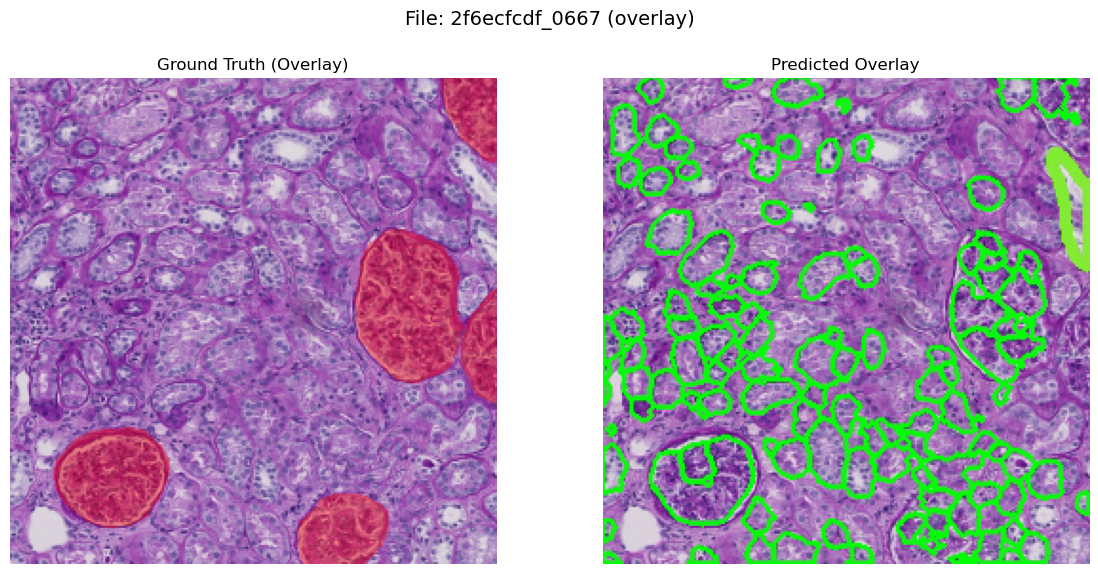


Attempting to visualize .MAT prediction from 'lumen_mat'...

--- Visualizing 1 samples for mat: ---


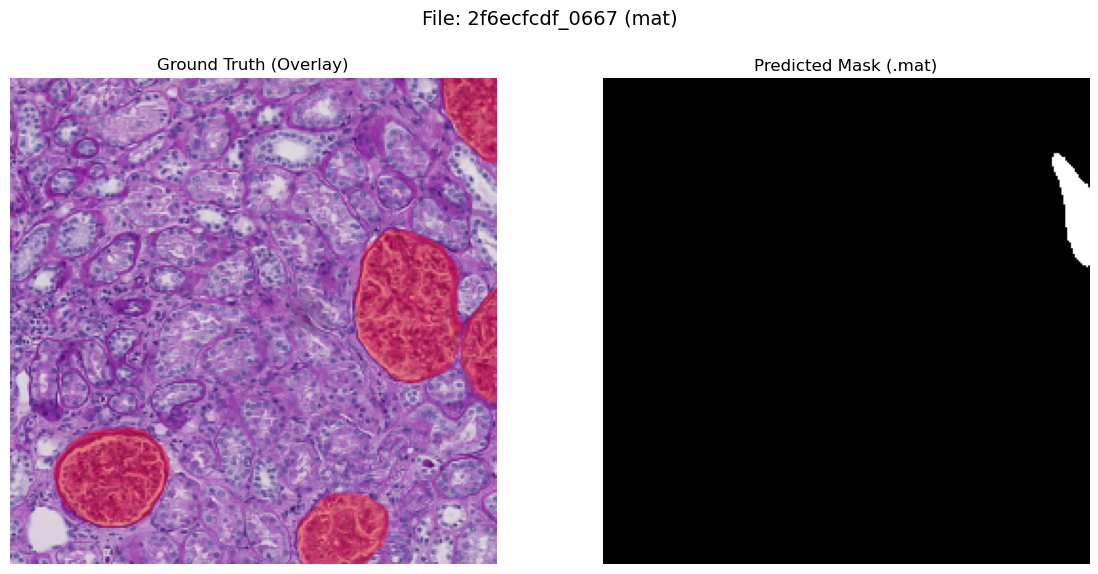


Attempting to visualize .MAT prediction from 'gland_mat'...

--- Visualizing 1 samples for mat: ---


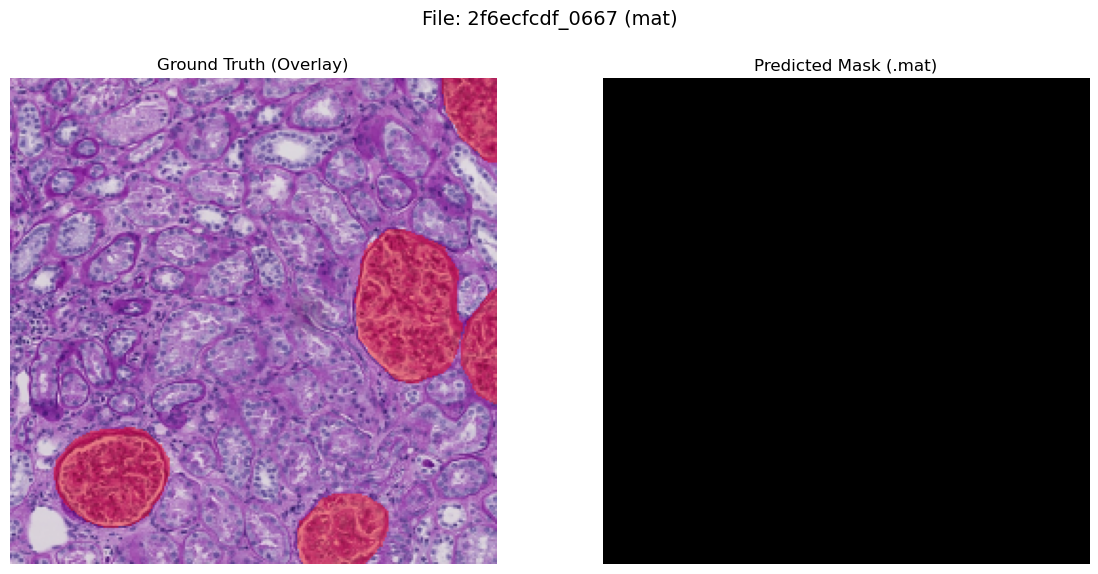


Attempting to visualize .MAT prediction from 'nuclei_mat'...

--- Visualizing 1 samples for mat: ---


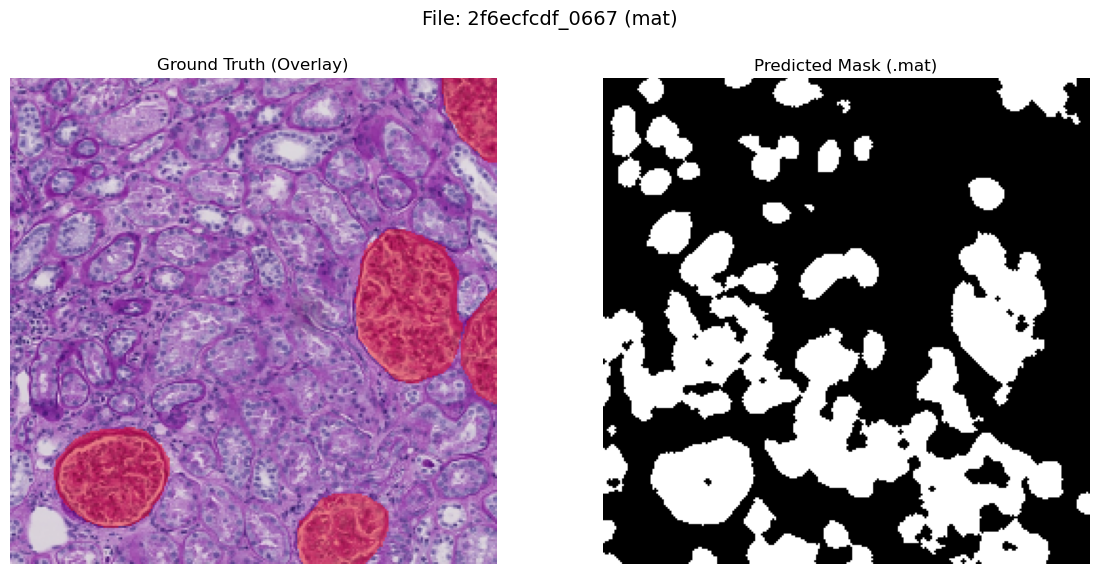


--- Finished visualizations for 2f6ecfcdf_0667.png ---


In [9]:
if __name__ == "__main__":
    config = get_script_config()
    eval()
    visual("2f6ecfcdf_0667.png")
